In [695]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import cv2
import os

import networkx as nx
from skimage.morphology import skeletonize, binary_closing, remove_small_objects, square
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph

# Load masks

In [696]:
roots_dir = f"..\\Task_6\\Kaggle\\root_systems"
roots_paths = sorted(glob.glob(os.path.join(roots_dir, "*.png")))
print("Found roots:", len(roots_paths))

Found roots: 95


# Display

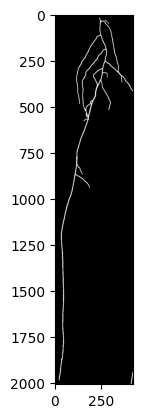

In [697]:
mask = cv2.imread(roots_paths[30], 0)
plt.imshow(mask, cmap='gray')

In [698]:
kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))
root_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_vert)

In [699]:
# plt.imshow(root_closed, cmap='gray')

# Skeletonize

In [700]:
close_k = 4

binary = (root_closed > 0).astype(np.uint8)
binary = binary_closing(binary, square(close_k))
num, labels = cv2.connectedComponents(binary.astype(np.uint8))
counts = np.bincount(labels.ravel())
main_label = counts[1:].argmax() + 1
binary = labels == main_label

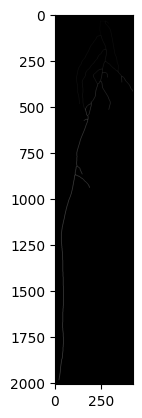

In [701]:
# binary = (mask > 0).astype(np.uint8)
skel = skeletonize(binary)

# 2) Build graph
skeleton = Skeleton(skel)
g0, c0 = skeleton_to_csgraph(skel)
plt.imshow(skeleton, cmap='gray')

<Axes: >

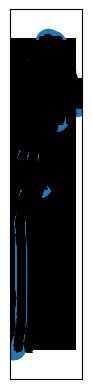

In [702]:
from skan import draw
fig, ax = plt.subplots()
draw.overlay_skeleton_networkx(g0, np.transpose(c0), image=skeleton, axis=ax)

In [703]:
branch_data = summarize(skeleton)
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,21,19.071068,1,1.0,0.0,20,242,37,247,20,242,37,247,17.720045
1,0,14,46,5.414214,1,1.0,0.0,33,273,38,274,33,273,38,274,5.099020
2,0,21,52,24.828427,2,1.0,0.0,37,247,39,271,37,247,39,271,24.083189
3,0,21,219,81.313708,2,1.0,0.0,37,247,115,247,37,247,115,247,78.000000
4,0,46,52,3.414214,2,1.0,0.0,38,274,39,271,38,274,39,271,3.162278
5,0,46,92,21.556349,1,1.0,0.0,38,274,51,289,38,274,51,289,19.849433
6,0,52,1045,301.480231,2,1.0,0.0,39,271,309,341,39,271,309,341,278.926514
7,0,219,1976,441.575685,1,1.0,0.0,115,247,487,132,115,247,487,132,389.370004
8,0,219,466,88.597980,2,1.0,0.0,115,247,191,276,115,247,191,276,81.344945
9,0,466,2091,394.504617,2,1.0,0.0,191,276,513,165,191,276,513,165,340.595067


In [704]:
# This is how we can convert the output of skan to a NetworkX graph
G = nx.from_pandas_edgelist(branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

In [705]:
coords = np.column_stack(c0)

In [706]:
G2 = nx.from_scipy_sparse_array(g0)

In [707]:
G.nodes

NodeView((0, 21, 14, 46, 52, 219, 92, 1045, 1976, 466, 2091, 736, 950, 1493, 1101, 1239, 1270, 1398, 1444, 1702, 2110, 1939, 1929, 1969, 2175, 2108, 2106, 2204, 2224, 2471, 2569, 2564, 3771, 2728))

# Root calculation

In [708]:
# y_by_node = {}
# for _, row in branch_data.iterrows():
#     y_by_node.setdefault(row['node-id-src'], row['coord-src-0'])
#     y_by_node.setdefault(row['node-id-dst'], row['coord-dst-0'])

In [709]:
# base = min(y_by_node, key=y_by_node.get).astype(int)

In [710]:
# base

In [711]:
# restrict to largest connected component
components = list(nx.connected_components(G2))
largest = max(components, key=len)
G2 = G2.subgraph(largest).copy()
coords_sub = coords

In [712]:
tips = [n for n, d in G2.degree() if d == 1]

In [713]:
tips

[0, 14, 92, 1270, 1444, 1702, 1929, 1976, 2106, 2110, 2224, 2564, 2728, 3771]

In [714]:
dist_from_tip = {}
for t in tips:
    try:
        dist_from_tip[t] = nx.single_source_dijkstra_path_length(G2, t, weight='weight')
    except nx.NetworkXNoPath:
        dist_from_tip[t] = {}

In [715]:
# viable = [t for t in tips if dist_from_tip[t] and max(dist_from_tip[t].values()) > 10]

In [716]:
# viable

In [717]:
base = min(largest, key=lambda n: (coords_sub[n, 0], coords_sub[n, 1]))

In [718]:
# coords = np.column_stack(c0)
# base = min(viable, key=lambda n: coords[n, 0])  # smallest y

In [719]:
dist = nx.single_source_dijkstra_path_length(G2, base, weight='weight')
far_tip = max(tips, key=lambda n: dist.get(n, -1))

In [720]:
far_tip

3771

In [721]:
path_idx = np.asarray(nx.shortest_path(G2, base, far_tip, weight='weight'), dtype=int)

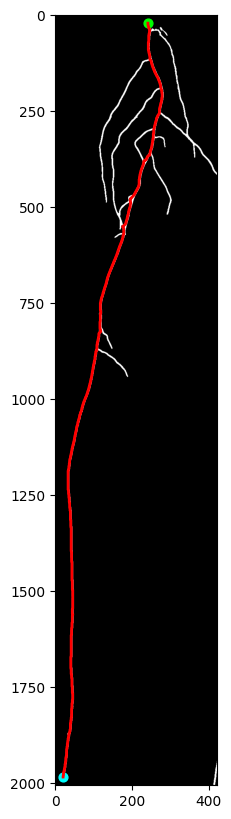

In [722]:
ys = coords[path_idx, 0]
xs = coords[path_idx, 1]

plt.figure(figsize=(4, 10))
plt.imshow(mask, cmap='gray')
plt.plot(xs, ys, 'r-', lw=2)
plt.scatter(xs[0], ys[0], c='lime', s=40)
plt.scatter(xs[-1], ys[-1], c='cyan', s=40)
plt.show()

In [ ]:
# # Evaluate each tip with dijkstra_path_length, pick the farthest
# best_tip = None
# best_len = -1.0 # it ensure that eny found path will be longer
# best_path = None

# for tip in tips:
#     try:
#         path_len = nx.dijkstra_path_length(G, base, tip, weight='branch-distance')
#     except nx.NetworkXNoPath:
#         continue
#     if path_len > best_len:
#         best_len = path_len
#         best_tip = tip
#         best_path = nx.dijkstra_path(G, base, tip, weight='branch-distance')

# primary_tip = best_tip
# primary_len_px = best_len
# primary_path = best_path

In [ ]:
# print('Primary tip', primary_tip, '; Lenght [px]:', primary_len_px)

Primary tip 12 ; Lenght [px]: 15.727922061357859


In [ ]:
# primary_path

[0, 23]

[ 0 12] int32 0 12 (2244, 2)


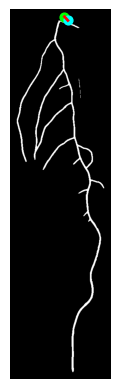

In [ ]:
# coords = np.column_stack(c0)            # (n_nodes, 2) y,x

# # ensure primary_path is a 1D int array
# path_idx = np.asarray(primary_path, dtype=int)

# print(path_idx[:5], path_idx.dtype, path_idx.min(), path_idx.max(), coords.shape)
# # path_idx.max() must be < coords.shape[0]

# ys = coords[path_idx, 0]
# xs = coords[path_idx, 1]

# plt.imshow(mask, cmap='gray')
# plt.plot(xs, ys, 'r-', lw=2)
# plt.scatter(xs[0], ys[0], c='lime', s=40)  # base
# plt.scatter(xs[-1], ys[-1], c='cyan', s=40)  # tip
# plt.axis('off')
# plt.show()


# Function with .csv output

In [487]:
def primary_length_px(img_path):
    mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return np.nan
    kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_vert)
    skel = skeletonize((mask_closed > 0).astype(np.uint8))
    g0, c0 = skeleton_to_csgraph(skel)

    coords = np.column_stack(c0)
    if coords.size == 0:
        return 0
    
    G = nx.from_scipy_sparse_array(g0)  # edges have 'weight'
    base = int(np.argmin(coords[:, 0]))           # topmost node
    tips = [n for n, d in G.degree() if d == 1]
    if not tips:
        return 0
    
    # Evaluate each tip with dijkstra_path_length, pick the farthest
    best_tip = None
    best_len = 0 # it ensure that any found path will be longer
    best_path = None

    for tip in tips:
        try:
            path_len = nx.dijkstra_path_length(G, base, tip, weight='branch-distance')
        except nx.NetworkXNoPath:
            continue
        if path_len > best_len:
            best_len = path_len
            best_tip = tip

    primary_len_px = best_len
    return primary_len_px

rows = []
for p in roots_paths:  # from your earlier cell
    plant_id = os.path.splitext(os.path.basename(p))[0]
    length_px = primary_length_px(p)
    rows.append({"Plant ID": plant_id, "Length (px)": length_px})

df = pd.DataFrame(rows)
df.to_csv("submission.csv", index=False)
df.head()


,Plant ID,Length (px)
0,test_image_01_plant_1,568
1,test_image_01_plant_2,12
2,test_image_01_plant_3,0
3,test_image_01_plant_4,29
4,test_image_01_plant_5,1429


In [555]:
def primary_length_px(img_path):
    close_k = 4

    mask = cv2.imread(img_path, 0)
    if mask is None:
        return 0
    
    # Close small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Binarize, close, keep only largest blob
    binary = (mask_closed > 0).astype(np.uint8)
    binary = binary_closing(binary, square(close_k))
    num, labels = cv2.connectedComponents(binary.astype(np.uint8))
    if num <= 1:
        return 0
    
    counts = np.bincount(labels.ravel())
    main_label = counts[1:].argmax() + 1
    binary = labels == main_label

    skel = skeletonize(binary)
    g0, c0 = skeleton_to_csgraph(skel)
    coords = np.column_stack(c0)
    if coords.size == 0 or g0.shape[0] == 0:
        return 0
    
    G = nx.from_scipy_sparse_array(g0)  # edges have 'weight'
    
    components = list(nx.connected_components(G))
    largest = max(components, key=len)
    G = G.subgraph(largest).copy()

    # filter nodes to those with valid coords indices
    valid_nodes = {n for n in G.nodes if n < coords.shape[0]}
    if not valid_nodes:
        return 0
    G = G.subgraph(valid_nodes).copy()
    
    # Tips and base
    tips = [n for n, d in G.degree() if d == 1]
    if not tips:
        return 0
    
    # base = topmost node in this component
    base = min(largest, key=lambda n: (coords[n, 0], coords[n, 1]))
    
    dist = nx.single_source_dijkstra_path_length(G, base, weight='weight')
    best_len = -1.0
    best_tip = None
    for tip in tips:
        L = dist.get(tip, -1)
        if L > best_len:
            best_len = L
            best_tip = tip

    if best_tip is None:
        return 0
    else:
        return best_len

rows = []
for p in roots_paths:  # from your earlier cell
    plant_id = os.path.splitext(os.path.basename(p))[0]
    length_px = primary_length_px(p)
    rows.append({"Plant ID": plant_id, "Length (px)": length_px})

df = pd.DataFrame(rows)
df.to_csv("submission.csv", index=False)
df.head()


,Plant ID,Length (px)
0,test_image_01_plant_1,641.658946
1,test_image_01_plant_2,1149.452886
2,test_image_01_plant_3,0.000000
3,test_image_01_plant_4,1285.298557
4,test_image_01_plant_5,1570.832611
